In [2]:
import pandas as pd
train = pd.read_csv(r"C:\Users\Adithya Sau\Downloads\playground-series-s5e1\train.csv")
test = pd.read_csv(r"C:\Users\Adithya Sau\Downloads\playground-series-s5e1\test.csv")
print(train.head())


   id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0


In [3]:
print(train['num_sold'].isnull().sum())
print(train['product'].value_counts())
print(train.isnull().sum())


8871
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64
id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


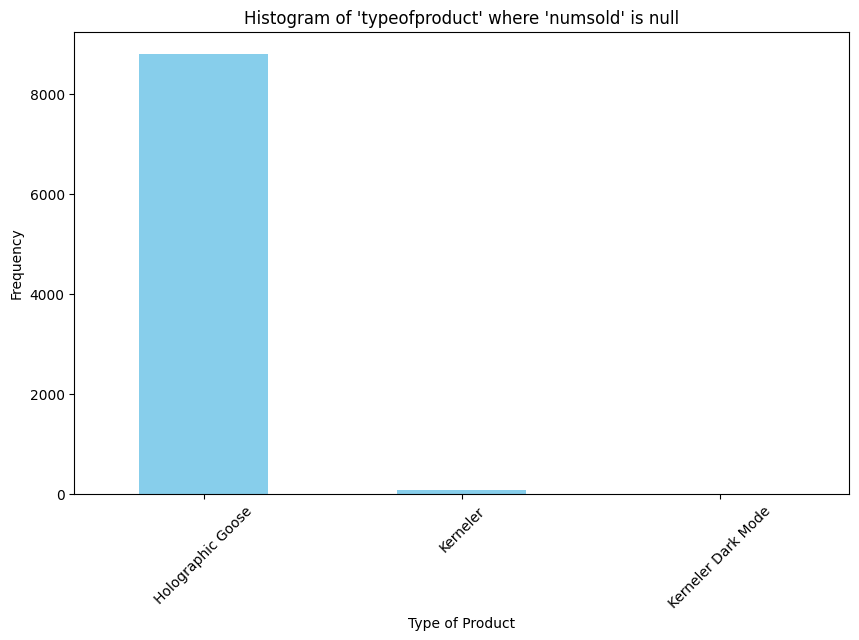

product
Holographic Goose     8806
Kerneler                64
Kerneler Dark Mode       1
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt

# Filter rows where 'numsold' is null
filtered_data = train[train['num_sold'].isnull()]

# Plot the histogram of 'typeofproduct' for rows where 'numsold' is null
plt.figure(figsize=(10, 6))
filtered_data['product'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Histogram of 'typeofproduct' where 'numsold' is null")
plt.xlabel("Type of Product")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()
print(filtered_data['product'].value_counts())

In [5]:
train["holiday"] = 0
test["holiday"] = 0


In [6]:
print(test["country"].unique())




['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']


In [7]:
import holidays

ca_holidays = holidays.country_holidays('CA') # Canada
fi_holidays = holidays.country_holidays('FI') # Finland
it_holidays = holidays.country_holidays('IT') # Italy
ke_holidays = holidays.country_holidays('KE') # Kenya
no_holidays = holidays.country_holidays('NO') # Norway
sg_holidays = holidays.country_holidays('SG') # Singapore


In [8]:
def set_holiday(row):
    VAL_HOLIDAY = 1
    if row["country"] == "Canada" and row["date"] in ca_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Finland" and row["date"] in fi_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Italy" and row["date"] in it_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Kenya" and row["date"] in ke_holidays:
        row["holiday"] = VAL_HOLIDAY


    elif row["country"] == "Norway" and row["date"] in no_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Singapore" and row["date"] in sg_holidays:
        row["holiday"] = VAL_HOLIDAY

    return row


In [9]:
train = train.apply(set_holiday, axis=1)
test = test.apply(set_holiday, axis=1)


In [10]:
print(train)

            id        date    country                 store  \
0            0  2010-01-01     Canada     Discount Stickers   
1            1  2010-01-01     Canada     Discount Stickers   
2            2  2010-01-01     Canada     Discount Stickers   
3            3  2010-01-01     Canada     Discount Stickers   
4            4  2010-01-01     Canada     Discount Stickers   
...        ...         ...        ...                   ...   
230125  230125  2016-12-31  Singapore  Premium Sticker Mart   
230126  230126  2016-12-31  Singapore  Premium Sticker Mart   
230127  230127  2016-12-31  Singapore  Premium Sticker Mart   
230128  230128  2016-12-31  Singapore  Premium Sticker Mart   
230129  230129  2016-12-31  Singapore  Premium Sticker Mart   

                   product  num_sold  holiday  
0        Holographic Goose       NaN        1  
1                   Kaggle     973.0        1  
2             Kaggle Tiers     906.0        1  
3                 Kerneler     423.0        1  
4  

In [11]:
print(train['holiday'].value_counts())
sum_holiday_0 = train.loc[train['holiday'] == 0, 'num_sold'].sum()
sum_holiday_1 = train.loc[train['holiday'] == 1, 'num_sold'].sum()

print(f"Sum where holiday = 0: {sum_holiday_0}")
print(f"Sum where holiday = 1: {sum_holiday_1}")
print(sum_holiday_0/223005)
print(sum_holiday_1/7125)


holiday
0    223005
1      7125
Name: count, dtype: int64
Sum where holiday = 0: 160964101.0
Sum where holiday = 1: 5539355.0
721.7959283424138
777.4533333333334


In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


train["num_sold"].fillna(train["num_sold"].median(), inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ["country", "store", "product"]:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Convert date to useful features
train["date"] = pd.to_datetime(train["date"])
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day"] = train["date"].dt.day
train["weekday"] = train["date"].dt.weekday
train.drop(columns=["date", "id"], inplace=True)

# Splitting features and target
X = train.drop(columns=["num_sold"])
y = train["num_sold"]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Regression output
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")


C:\Users\Adithya Sau\AppData\Local\Temp\ipykernel_43932\3130144406.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["num_sold"].fillna(train["num_sold"].median(), inplace=True)


Epoch 1/50
5754/5754 [==============================] - 21s 3ms/step - loss: 346556.2500 - mae: 419.3000 - val_loss: 137659.2344 - val_mae: 244.0511
Epoch 2/50
5754/5754 [==============================] - 19s 3ms/step - loss: 54562.7070 - mae: 153.0797 - val_loss: 29797.0371 - val_mae: 116.3251
Epoch 3/50
5754/5754 [==============================] - 19s 3ms/step - loss: 25158.9668 - mae: 105.5172 - val_loss: 21020.2910 - val_mae: 95.5455
Epoch 4/50
5754/5754 [==============================] - 19s 3ms/step - loss: 19137.8691 - mae: 92.2882 - val_loss: 17379.2070 - val_mae: 89.6548
Epoch 5/50
5754/5754 [==============================] - 19s 3ms/step - loss: 16814.6152 - mae: 86.9134 - val_loss: 15848.0273 - val_mae: 85.1155
Epoch 6/50
5754/5754 [==============================] - 19s 3ms/step - loss: 15638.4795 - mae: 84.2155 - val_loss: 16417.6074 - val_mae: 86.6647
Epoch 7/50
5754/5754 [==============================] - 20s 3ms/step - loss: 14671.6738 - mae: 81.8580 - val_loss: 14221.00

In [14]:
  # Replace with actual file path
test["date"] = pd.to_datetime(test["date"])
test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["day"] = test["date"].dt.day
test["weekday"] = test["date"].dt.weekday

# Preserve id column
test_ids = test["id"].copy()
test.drop(columns=["date", "id"], inplace=True)

# Encode categorical variables in test data
for col in ["country", "store", "product"]:
    if col in label_encoders:
        test[col] = label_encoders[col].transform(test[col])

# Standardize numerical features in test data
X_test_final = scaler.transform(test)

# Make predictions on the test dataset
test_predictions = model.predict(X_test_final)

# Create a new DataFrame with id and num_sold
output = pd.DataFrame({"id": test_ids, "num_sold": test_predictions.flatten()})
output.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")

3080/3080 [==============================] - 7s 2ms/step
Predictions saved to test_predictions.csv
